In [1]:
import time
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib as mpt
import numpy as np
import pickle as pkl
import statsmodels.stats.multitest as multitest
import seaborn as sns
from scipy.stats import ttest_ind, mannwhitneyu

In [2]:
%matplotlib inline

In [3]:
mpt.rcParams['figure.dpi'] = 300

# Meta-data

In [4]:
# dataset, Group1, Group2 = 'MPI_LEMON', 'Young', 'Elderly'
dataset, Group1, Group2 = 'ABIDE', 'Healthy', 'ASD'

RSNs7 = ['Visual', 'Somato Motor', 'Dorsal Attention', 'Salient Ventral Attention', 'Limbic', 'Control', 'Default']
metadata = {'pe_dim':{}, 'L1_norm': {}, 'L2_norm': {}}

inpath = f'../OutputFiles/PosCorr/{dataset}/Output_RSNs/'

for RSN in RSNs7:
    rsn = RSN.replace(' ','')
    metadata['L1_norm'][rsn] = {}
    metadata['L2_norm'][rsn] = {}
    metadata['pe_dim'][rsn] = {}
    for grp in [Group1, Group2]:
        Global_data = pd.read_csv(inpath + f'{rsn}/{rsn}_{grp}_L1L2PE.txt', sep = '\t')
        metadata['L1_norm'][rsn][grp] =  Global_data['L1_norm'].to_list()
        metadata['L2_norm'][rsn][grp] =  Global_data['L2_norm'].to_list()
        metadata['pe_dim'][rsn][grp] =  Global_data['pe_dim'].to_list()
        SubID_list = Global_data['SubID'].to_list()
    print(rsn, grp)

Visual ASD
SomatoMotor ASD
DorsalAttention ASD
SalientVentralAttention ASD
Limbic ASD
Control ASD
Default ASD


['pe_dim', 'L1_norm', 'L2_norm']
pe_dim [0.8306681122, 2.64147e-05, 0.8306681122, 2.94442e-05, 0.8306681122, 0.8306681122, 2.1e-09]
L1_norm [0.1284034817, 0.0008841362, 0.1284034817, 0.0007954384, 0.5323828913, 0.8538063939, 7.275e-07]
L2_norm [0.2745611915, 0.0139936863, 0.1249006752, 0.0011444525, 0.9831429689, 0.9831429689, 0.0001275912]


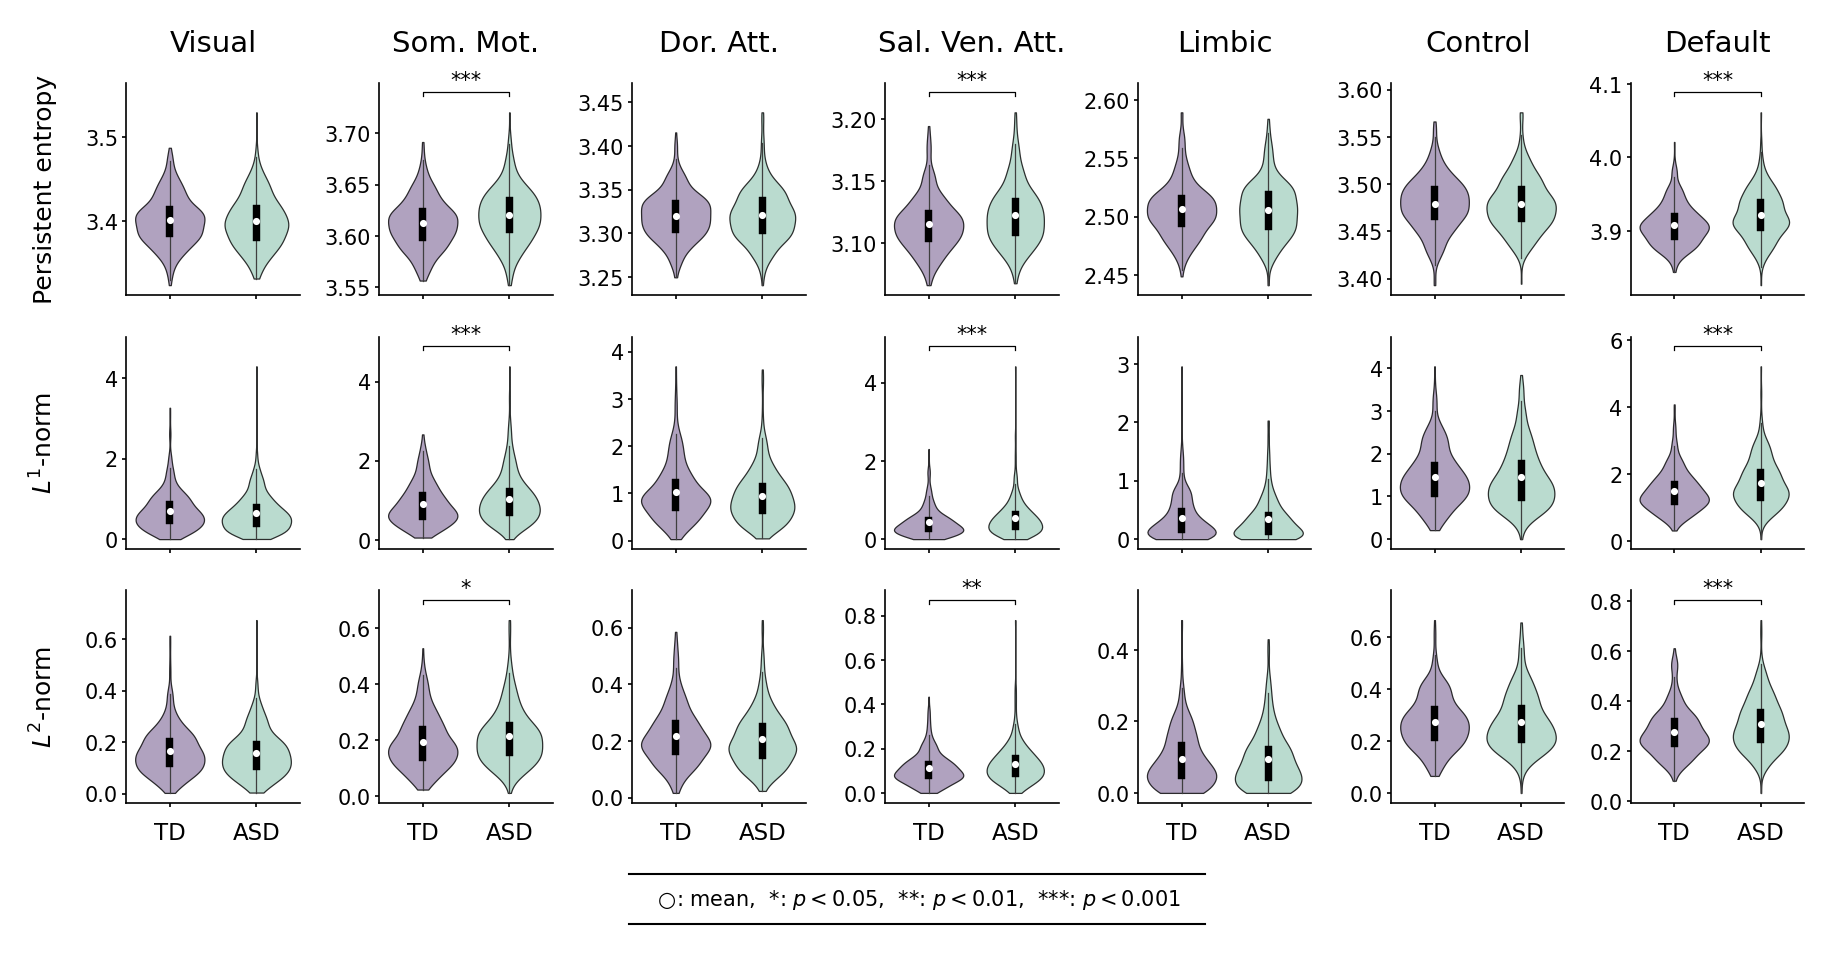

ABIDE 1.505845546722412


In [5]:
# Generate sample data
t0 = time.time()
Ylabels = ['Persistent entropy', '$L^1$-norm', '$L^2$-norm']

if dataset == 'MPI_LEMON':
    g1,g2 = 'Young', 'Elderly'
    x_label_list = ['Young', 'Elderly']
    Colors = ["darkgray", "navajowhite"]
elif dataset == 'ABIDE':
    g1,g2 = 'Healthy', 'ASD'
    x_label_list = ['TD', 'ASD']
    Colors = ["#9c8bb0", "#a9d2c3"]

Titels = ['Visual', 'Som. Mot.', 'Dor. Att.', 'Sal. Ven. Att.', 'Limbic', 'Control', 'Default']
rows, cols = 3, 7
fig, axes = plt.subplots(rows, cols, figsize=(6, 2.8), constrained_layout=True)
keys1 = list(metadata.keys())
print(keys1)
p_values_dict = {}
# Loop through rows and columns
for i in range(rows):
    key1 = keys1[i]
    p_values_dict[key1] = []
    p_values = []
    keys2 = list(metadata[key1].keys())
    for j in range(cols):
        key2 = keys2[j]
        # print(i,j,key1, key2)
        data1 = metadata[key1][key2][g1]
        data2 = metadata[key1][key2][g2]
        
        # Perform t-test and store p-value
        p_value = ttest_ind(data1, data2, equal_var=False)[1]
        p_values.append(p_value)
    correction = multitest.multipletests(p_values, alpha=0.05, method = 'fdr_bh')
    fdr = correction[0]
    fdr_corrected = correction[1]
    p_values_dict[key1].extend(fdr_corrected)
    print(key1, list(np.round(np.array(list(fdr_corrected)), 10)))
    for j in range(cols):
        key2 = keys2[j]
        
        data1 = metadata[key1][key2][g1] 
        data2 = metadata[key1][key2][g2]
        # Plot violin plots
        data = [data1, data2]

        violin = sns.violinplot(data=data, ax=axes[i, j], cut = 0, inner=None)#, saturation=2)
        for ord, body in enumerate(violin.collections):  
            body.set_facecolor(Colors[ord])  
            body.set_alpha(0.8)
            body.set_edgecolor("black")
            body.set_linewidth(0.3)
        sns.boxplot(data=data, ax=axes[i, j], width=0.08, showcaps=False, showfliers=False, whiskerprops={'linewidth': 0.3},
                    boxprops={'facecolor': 'black', 'edgecolor': 'black', 'linewidth': 0.1, 'zorder': 3})#,
        axes[i,j].spines[['top','right']].set_visible(False)
        bottom, top = axes[i,j].get_ylim()
        y_range = top - bottom
        x1, x2 = 0, 1
        level = 2 
        bar_height = (y_range * 0.03 * level) + top
        bar_tips = bar_height - (y_range * 0.02)
        text_height = bar_height + (y_range * 0.01)
        p = fdr_corrected[j]
        if p < 0.001:
            sig_symbol = '***'
            axes[i,j].plot([x1, x1, x2, x2], [bar_tips, bar_height, bar_height, bar_tips], lw=0.3, c='k')
            axes[i,j].text((x1 + x2) * 0.5, text_height, sig_symbol, ha='center', va='bottom', c='k', fontsize = 5)
        elif p < 0.01:
            sig_symbol = '**'
            axes[i,j].plot([x1, x1, x2, x2], [bar_tips, bar_height, bar_height, bar_tips], lw=0.3, c='k')
            axes[i,j].text((x1 + x2) * 0.5, text_height, sig_symbol, ha='center', va='bottom', c='k', fontsize = 5)
        elif p < 0.05:
            sig_symbol = '*'
            axes[i,j].plot([x1, x1, x2, x2], [bar_tips, bar_height, bar_height, bar_tips], lw=0.3, c='k')
            axes[i,j].text((x1 + x2) * 0.5, text_height, sig_symbol, ha='center', va='bottom', c='k', fontsize = 5)
        else:
            sig_symbol = 'X'#'p > 0.05'
            axes[i,j].plot([x1, x1, x2, x2], [bar_tips, bar_height, bar_height, bar_tips], lw=0.3, c='w')
        means = [np.mean(data1), np.mean(data2)]
        for num, mean in enumerate(means):
            axes[i,j].scatter(num, mean, color='white', marker='o', s=0.5, zorder=5, label='Mean' if num == 0 else "")
            
        axes[i, j].set_ylabel(Ylabels[i] if j == 0 else "", fontsize = 6)
        if dataset == 'MPI_LEMON':
            axes[i, 0].yaxis.set_label_coords(-0.35, 0.5)
        else:
            axes[i, 0].yaxis.set_label_coords(-0.4, 0.5)
        # X-titles only for the first row
        axes[i, j].set_title(Titels[j] if i == 0 else "", fontsize = 7, y = 1.03)
        axes[i, j].set_xticklabels(x_label_list if i == 2 else "", fontsize=5.5)
        axes[i,j].tick_params(axis='y', labelsize=5, width=0.4, pad=1, length=1)
        axes[i,j].tick_params(axis='x', width=0.4, length=1)
        axes[i,j].spines['bottom'].set_linewidth(0.4)
        axes[i,j].spines['left'].set_linewidth(0.4)


text_x = 0.5
text_y = -0.05
fig.text(text_x, text_y, r'   $\bigcirc$: mean,  *: $p < 0.05$,  **: $p < 0.01$,  ***: $p < 0.001$   ',ha='center', va='center', fontsize=5)
line_length = 0.32  # Length of the line (20% of figure width)
line_x_start = text_x - line_length / 2
line_x_end = text_x + line_length / 2
line_y_top = text_y + 0.03
line_y_bottom = text_y - 0.03

line_top = Line2D([line_x_start, line_x_end], [line_y_top, line_y_top], transform=fig.transFigure, color='black', linewidth=0.5)
line_bottom = Line2D([line_x_start, line_x_end], [line_y_bottom, line_y_bottom], transform=fig.transFigure, color='black', linewidth=0.5)
fig.lines.extend([line_top, line_bottom])
# plt.savefig(f'../OutputFiles/Output_Plots/{dataset}_violin_RSNs_PosCorr_PEL1L2.pdf',bbox_inches='tight', dpi= 600)

plt.show()
print(dataset, time.time() - t0)